### v3 changelog:
- integrates adaptor
- extract parameter names
- adds monitor
- adds skip frames

In [1]:
import math
import os
import random

from typing import  Dict, List, Tuple
from collections import  OrderedDict
from importlib import reload

import utils_rainbow
reload(utils_rainbow)
from utils_rainbow import PrioritizedReplayBuffer, ReplayBuffer, AdaptorRainbow
from utils import seed_everything, Monitor
import models_rainbow
reload(models_rainbow)
from models_rainbow import Network 
import env_wrappers
reload(env_wrappers)
from env_wrappers import StackFrames

import minerl
import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from torch.nn.utils import clip_grad_norm_
from tqdm import tqdm
import pickle

torch.backends.cudnn.benchmark=True

In [2]:
# Environment parameters
VERSION = 'rainbow_v3'
ENV_NAME = 'MineRLTreechop-v0'
POV_DIM = 64*64*3
NON_POV_DIM = 0
obs_dim = POV_DIM + NON_POV_DIM

# training parameters
NUM_FRAMES = 10000000
MEMORY_SIZE = 300000
BATCH_SIZE = 32
TARGET_UPDATE = 1000
LEARNING_RATE = 0.0000625

# This summarises the number of actions
# The keys of the ACTIONS_DICT will correspond to the action the model will take (number is not relevant, is just the number)
# and the values is the corrresponding action in the environment

ALWAYS_KEYS = {'attack': 1,
               'forward': 1 }

ACTION_DICT = OrderedDict({  
   #'camera_left' : {'camera': [ 0, -20]},
   #'camera_right' : {'camera': [ 0, 20]},
   'camera_left_little' : {'camera': [ 0, -3]}, 
   'camera_right_little' : {'camera': [ 0, 3]},
   'jump' : {'jump':1},
   #'left' : {'left':1},
   #'right' : {'right':1}, 
   #'sneak+forward' : {'sneak': 1, 'jump':1},
   #'wait': {},
    'stop': {'forward':0}
    })

# Seed
SEED = 777

# RL parameters 
GAMMA = 0.99

# Prioritise experience replay parameters
ALPHA = 0.6
BETA = 0.4
PER_EPSILON = 1e-6

# Categorical DQN parameters. V_MIN and V_MAX are the max and min values that the DQN Network can have, i.e. the Q network
V_MIN = 0
V_MAX = 180
ATOM_SIZE = 51

# N_STEP learning (step number to calculate n-step td error)
N_STEP = 10

# Noisy linear layer
STD_NOISY = 0.5

monitor = Monitor('monitor_'+VERSION+'.pkl', 'monitoring')

In [3]:
class DQNAgent:
    """DQN Agent interacting with environment.
    
    Attribute:
        env (gym.Env): openAI Gym environment
        memory (PrioritizedReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        target_update (int): period for target model's hard update
        gamma (float): discount factor
        dqn (Network): model to train and select actions
        dqn_target (Network): target model to update
        optimizer (torch.optim): optimizer for training dqn
        transition (list): transition information including 
                           state, action, reward, next_state, done
        v_min (float): min value of support
        v_max (float): max value of support
        atom_size (int): the unit number of support
        support (torch.Tensor): support for categorical dqn
        use_n_step (bool): whether to use n_step memory
        n_step (int): step number to calculate n-step td error
        memory_n (ReplayBuffer): n-step replay buffer
    """

    def __init__(
        self, 
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        target_update: int,
        pov_dim: int,
        non_pov_dim: int,
        gamma: float,
        alpha: float,
        beta: float,
        prior_eps: float,
        v_min: float,
        v_max: float,
        atom_size: int,
        n_step: int,
        std_noisy: float,
        adaptor: AdaptorRainbow,  # AdaptorRainbow is the type
        action_dim: int,
        learning_rate: float
    ):
     
        self.non_pov_dim = non_pov_dim
        # action_dim = env.action_space.n
        
        self.env = env
        self.batch_size = batch_size
        self.target_update = target_update
        self.gamma = gamma
        # NoisyNet: All attributes related to epsilon are removed
        
        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)
        
        # PER
        # memory for 1-step Learning
        self.beta = beta
        self.prior_eps = prior_eps
        self.memory = PrioritizedReplayBuffer(
            pov_dim+non_pov_dim, memory_size, batch_size, alpha=alpha
        )
        
        # memory for N-step Learning
        self.use_n_step = True if n_step > 1 else False
        if self.use_n_step:
            self.n_step = n_step
            self.memory_n = ReplayBuffer(
                 pov_dim+non_pov_dim, memory_size, batch_size, n_step=n_step, gamma=gamma
            )
            
        # Categorical DQN parameters
        self.v_min = v_min
        self.v_max = v_max
        self.atom_size = atom_size
        self.support = torch.linspace(
            self.v_min, self.v_max, self.atom_size
        ).to(self.device)

        # networks: dqn, dqn_target
        self.dqn = Network(
            action_dim, self.atom_size, non_pov_dim, self.support, std_noisy
        ).to(self.device)
        self.dqn_target = Network(
            action_dim, self.atom_size, non_pov_dim, self.support, std_noisy
        ).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()
        
        # optimizer
        self.optimizer = optim.Adam(self.dqn.parameters(), lr=learning_rate)

        # transition to store in memory
        self.transition = list()
        
        # mode: train / test
        self.is_test = False
        self.scores = None
        
        # adaptor
        self.ad = adaptor

        
    def select_action(self, env_obs: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        # NoisyNet: no epsilon greedy action selection
        selected_action = self.dqn(
            self.ad.env2model(env_obs), None
        ).argmax()
        selected_action = selected_action.detach().cpu().numpy()
        
        if not self.is_test:
            self.transition = [ self.ad.flatten_obs(env_obs), selected_action ]
        
        return selected_action

    
    def step(self, action_number: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        action_dict = self.ad.model_act2env_act(action_number)
        next_state, reward, done = self.env.step(action_dict)
        
        if not self.is_test:
            self.transition += [reward, self.ad.flatten_obs(next_state), done]
            
            # N-step transition
            if self.use_n_step:
                one_step_transition = self.memory_n.store(*self.transition)
            # 1-step transition
            else:
                one_step_transition = self.transition

            # add a single step transition
            if one_step_transition:
                self.memory.store(*one_step_transition)
    
        return next_state, reward, done

    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        # PER needs beta to calculate weights
        samples = self.memory.sample_batch(self.beta)
        weights = self.ad.float_tensor( samples["weights"].reshape(-1, 1) )
        indices = samples["indices"]
        
        # 1-step Learning loss
        elementwise_loss = self._compute_dqn_loss(samples, self.gamma)
        
        # PER: importance sampling before average
        loss = torch.mean(elementwise_loss * weights)
        
        # N-step Learning loss
        # we are gonna combine 1-step loss and n-step loss so as to
        # prevent high-variance. The original rainbow employs n-step loss only.
        if self.use_n_step:
            gamma = self.gamma ** self.n_step
            samples = self.memory_n.sample_batch_from_idxs(indices)
            elementwise_loss_n_loss = self._compute_dqn_loss(samples, gamma)
            elementwise_loss += elementwise_loss_n_loss
            
            # PER: importance sampling before average
            loss = torch.mean(elementwise_loss * weights)

        self.optimizer.zero_grad()
        loss.backward()
        # gradient clipping
        # https://pytorch.org/docs/stable/nn.html#torch.nn.utils.clip_grad_norm_
        clip_grad_norm_(self.dqn.parameters(), 1.0, norm_type=1)
        self.optimizer.step()
        
        # PER: update priorities
        loss_for_prior = elementwise_loss.detach().cpu().numpy()
        new_priorities = loss_for_prior + self.prior_eps
        self.memory.update_priorities(indices, new_priorities)
        
        # NoisyNet: reset noise
        self.dqn.reset_noise()
        self.dqn_target.reset_noise()

        return loss.item()

    
    def _compute_dqn_loss(self, samples: Dict[str, np.ndarray], gamma: float) -> torch.Tensor:
        """Return categorical dqn loss."""        
        obss, obss_rest, next_obss, next_obss_rest, action, reward, done = self.ad.buffer2train(samples)
        
        # Categorical DQN algorithm
        delta_z = float(self.v_max - self.v_min) / (self.atom_size - 1)

        with torch.no_grad():
            # Double DQN
            next_action = self.dqn(next_obss, 
                                   next_obss_rest).argmax(1)
            next_dist = self.dqn_target.dist(next_obss, 
                                   next_obss_rest)
            next_dist = next_dist[range(self.batch_size), 
                                  next_action]

            t_z = reward + (1 - done) * gamma * self.support
            t_z = t_z.clamp(min=self.v_min, max=self.v_max)
            b = (t_z - self.v_min) / delta_z
            l = b.floor().long()
            u = b.ceil().long()

            offset = (
                torch.linspace(
                    0, (self.batch_size - 1) * self.atom_size, self.batch_size
                ).long()
                .unsqueeze(1)
                .expand(self.batch_size, self.atom_size)
                .to(self.device)
            )

            proj_dist = torch.zeros(next_dist.size(), device=self.device)
            proj_dist.view(-1).index_add_(
                0, (l + offset).view(-1), (next_dist * (u.float() - b)).view(-1)
            )
            proj_dist.view(-1).index_add_(
                0, (u + offset).view(-1), (next_dist * (b - l.float())).view(-1)
            )

        dist = self.dqn.dist(obss, obss_rest)
        log_p = torch.log(dist[range(self.batch_size), action])
        elementwise_loss = -(proj_dist * log_p).sum(1)

        return elementwise_loss

    def _target_hard_update(self):
        """Hard update: target <- local."""
        self.dqn_target.load_state_dict(self.dqn.state_dict())

## Environment

You can see the [code](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py) and [configurations](https://github.com/openai/gym/blob/master/gym/envs/__init__.py#L53) of CartPole-v0 from OpenAI's repository.

In [4]:
if 'env' not in locals():
    %time env = StackFrames( env=gym.make(ENV_NAME), steps=4, only_last=True )

seed_everything(seed=SEED, env=env)

CPU times: user 150 ms, sys: 293 ms, total: 443 ms
Wall time: 58.7 s


## Initialize

In [5]:
# train
adaptor = AdaptorRainbow(obs_rest=False, actions_dict=ACTION_DICT, always_keys=ALWAYS_KEYS)
agent = DQNAgent(env, 
                 memory_size=MEMORY_SIZE, 
                 batch_size=BATCH_SIZE, 
                 target_update=TARGET_UPDATE, 
                 pov_dim=POV_DIM, 
                 non_pov_dim=NON_POV_DIM, 
                 gamma= GAMMA, 
                 alpha=ALPHA, 
                 beta=BETA,
                 prior_eps=PER_EPSILON, 
                 v_min=V_MIN, 
                 v_max=V_MAX,
                 atom_size=ATOM_SIZE,
                 n_step=N_STEP,
                 std_noisy=STD_NOISY,
                 adaptor=adaptor,
                 action_dim=len(ACTION_DICT),
                 learning_rate=LEARNING_RATE
                )

# number of trainable parameters of model
print('number of trainable parameters:', sum(p.numel() for p in agent.dqn.parameters()  if p.requires_grad))

cuda
number of trainable parameters: 798238


## Train

In [6]:
"""Train the agent."""
state = env.reset()
update_cnt = 0
trajectory_count = 0
max_parameters = []
plotting_interval = 300
score = 0

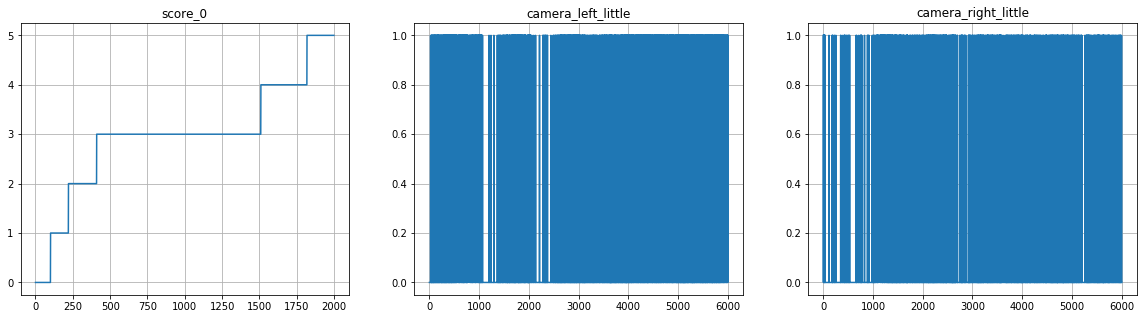

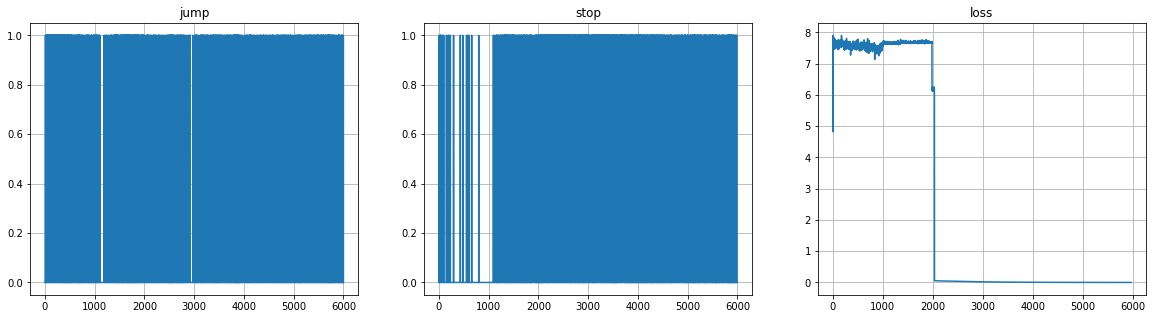

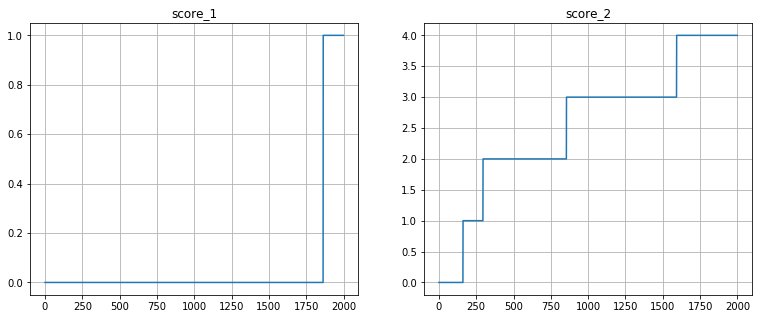

  0%|          | 6170/10000000 [27:10<665:32:25,  4.17it/s]  

In [ ]:
for frame_idx in tqdm(range(1, NUM_FRAMES + 1)):
    action = agent.select_action(state)

    next_state, reward, done = agent.step(action)
    state = next_state
    score += reward
    # NoisyNet: removed decrease of epsilon

    # PER: increase beta
    fraction = min(frame_idx / NUM_FRAMES, 1.0)
    agent.beta = agent.beta + fraction * (1.0 - agent.beta)
    
    # monitoring
    monitor.add(f'score_{trajectory_count}', score)
    monitor.add(list(ACTION_DICT.keys()),np.eye(len(ACTION_DICT))[action] )
    
    if done:
        state = env.reset()           
        current_score = []
        score = 0
        trajectory_count+=1

    # Train
    if len(agent.memory) >= agent.batch_size:
        loss = agent.update_model()
        monitor.add('loss', loss)
        update_cnt += 1

        # Hard update
        if update_cnt % agent.target_update == 0:
            agent._target_hard_update()

    # plotting
    if frame_idx % plotting_interval == 0:
        clear_output(True)
        monitor.plot_all()
        monitor.save()
        torch.save(agent.dqn.state_dict(), 'rainbow_model.torch')
        torch.save(agent.dqn_target.state_dict(), 'rainbow_model.torch')
        
env.close()